#### Solve evolution equation of phi and background evolution simultaneously

In [1]:
import numpy as np, constant as C
from scipy.integrate import solve_ivp
from scipy.optimize import root
from matplotlib.pyplot import *

In [2]:
# Define constants (use Mpc unit)
H0    = 67.36
Om    = 0.3153
zeq   = 3402
# derived cosmological parameters
aeq   = 1./(1.+zeq)
h0    = H0/100.
H0Mpc = H0/C.C
Or    = Om*aeq
Ov    = 1-Om # flat universe
rhoc  = C.rho_c_Mpc4*(h0**2)

In [3]:
# Initial conditions
dphi0 = 0.0
a0 = 1e-7
t_steps = 1000

In [4]:
# Define the potential and its derivative
def V(m,phi):
    return m**2 * phi**2 / 2
def dV_dphi(m,phi):
    return m**2 * phi

In [29]:
def equations_nb(t, y, m):
    phi, dphi, a = y
    rho_phi = dphi**2/2. + V(m,phi)
    H = H0Mpc * np.sqrt( Om/a**3 + Or/a**4 + 1-Om) 
    ddphi = -3 * H * dphi - dV_dphi(m,phi)
    da = H * a
    return [dphi, ddphi, da]

In [6]:
# System of ODEs
def equations(t, y, m):
    phi, dphi, a = y
    rho_phi = dphi**2/2. + V(m,phi)
    H = H0Mpc * np.sqrt( rho_phi/rhoc + Om/a**3 + Or/a**4 ) 
    ddphi = -3 * H * dphi - dV_dphi(m,phi)
    da = H * a
    return [dphi, ddphi, da]

In [7]:
# Iteratively adjust phi to satisfy rho_phi = Omega_Lambda x rho_c and a = 1
def residual(guess):
    # Initial conditions
    t_span = (0, guess[1])
    t_eval = np.linspace(t_span[0], t_span[1], t_steps)
        
    # Solve the system over some time range
    sol = solve_ivp(equations, t_span, [guess[0], dphi0, a0], args=(m,), dense_output=True)
        
    # Get the solution at t=t_end
    phi_end  = sol.sol(t_span[1])[0]
    dphi_end = sol.sol(t_span[1])[1]
    a_end    = sol.sol(t_span[1])[2]
    rho_end  = dphi_end**2/2. + V(phi_end,m)
    
    print(phi_end,a_end)
    
    return [rho_end/rhoc-(1-Om),a_end-1]

In [8]:
m = 1e-35*C.eV2Mpc
phi_ini_guess = np.sqrt(2.*rhoc*(1.-Om))/m # initial guess, assuming slow roll
result = root(residual, [phi_ini_guess,4100])

1.1092101853139238e+59 0.9711143301371387
1.1092101853139238e+59 0.9711143301371387
1.1092101853139238e+59 0.9711143301371387
1.109210201842459e+59 0.9711143340171388
1.1092101853137302e+59 0.9711143436604189
1.1092152658946336e+59 1.000218296740591
1.109215270758662e+59 0.9999983444634396
1.1092152707162891e+59 0.9999999999046515
1.1092152707162865e+59 1.0


In [9]:
print(result.x[0],phi_ini_guess)

1.1092226982318044e+59 1.1092171981651145e+59


In [51]:
# No back reaction to H
t_eval_nb = np.linspace(0, 4230, t_steps)
sol = solve_ivp(equations_nb, [0,4230], [result.x[0], dphi0, a0], args=(m,), t_eval=t_eval_nb)
# Extract results
phi_nb, a_nb = sol.y[0], sol.y[2]

In [52]:
# Solve the full system with the corrected initial condition
t_eval = np.linspace(0, result.x[1], t_steps)
sol = solve_ivp(equations, [0,result.x[1]], [result.x[0], dphi0, a0], args=(m,), t_eval=t_eval)
# Extract results
phi, a = sol.y[0], sol.y[2]

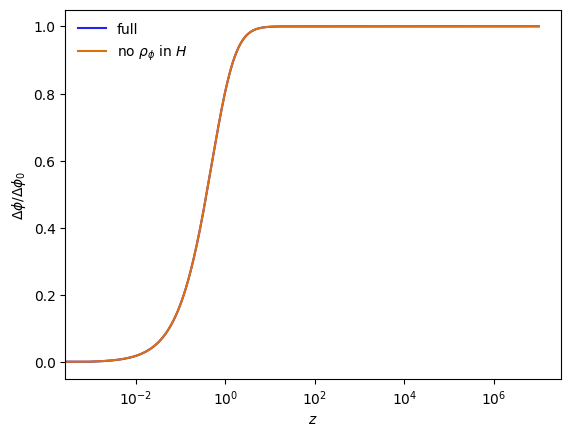

In [53]:
xscale('log')
plot(1./a-1, (phi-phi[-1])/(phi[0]-phi[-1]),label='full')
plot(1./a_nb-1, (phi_nb-phi_nb[-1])/(phi_nb[0]-phi_nb[-1]),label=r'no $\rho_\phi$ in $H$')
xlabel(r'$z$')
ylabel(r'$\Delta\phi/\Delta\phi_0$')
legend()

Text(0, 0.5, '$a$')

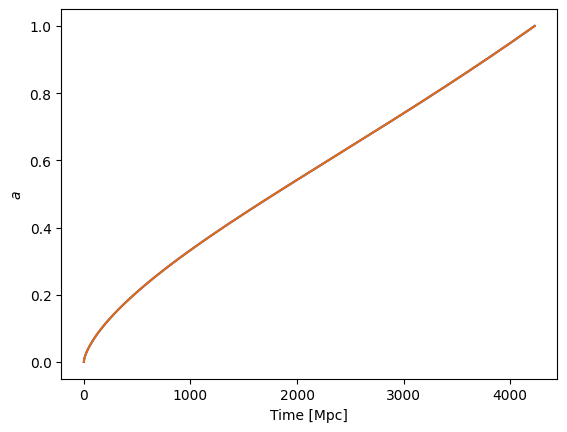

In [54]:
plot(t_eval, a)
plot(t_eval_nb, a_nb)
xlabel('Time [Mpc]')
ylabel(r'$a$')

In [13]:
# rotation angle
g = 3e-18 / (1e9*C.eV2Mpc) # g: /GeV^-1 is a rough value taken from the maximum value in arXiv:2008.02473
print(g*(phi[0]-phi[-1])/2 * 180./np.pi, 'deg')

0.4082189462490118 deg
